## Example script plotting enviromental data measured by AIRDOS04

The following code demonstrates the method how to plot cabin air data measured by [AIRDOS04A](https://docs.dos.ust.cz/airdos/AIRDOS04). The following proces expect the user is familiar with concept of [jupiter notebooks](https://jupyter.org/) and have a basic knowledge of [Python3](https://www.python.org/) programming language.

For demonstration we use an data recording contained in the AIRDOS04 repository and logged by experimental beta release of the firmware. 

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from IPython.display import Image as ImageDisp
from pandas import DataFrame
import string
import os
import glob
import matplotlib.pyplot as plt
import matplotlib
import re

directory = './tests/' # Directory with data 

FIRST_CHANNEL = 8 # a column of the 1st channel without noise
ZERO_CHANNEL = 4 # a column of the channel with maximal noise
CH_WIDTH = 0.0066 # [MeV]

Because the AIRDOS04 originally produces multiple files to record data in sufficiently long chunks, there could be multiple text files, which wee need to concanetate along measurement runs. The example recorded file has been anonymised therefore serial numbers here are displayed as `ffffffffffffffffffffffffffffffff` for valid AIRDOS04 product, there should be an proper serial number of the device. 

In [2]:
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

df=pd.DataFrame()

sn = '0'
files = sorted(glob.iglob(directory + '/*.TXT'), key=numericalSort)
for file in files:
    print(file)
    l=[]
    l.extend(range(0,1028))
    f = pd.read_csv(file, sep=',', header=None, names=l, comment='*', low_memory=False)
    try:
        sn = f.loc[f[0]=='$DOS'].iloc[0,6]
        print("S.N.: ", sn)
    except:
        pass
    df = pd.concat([df,f], ignore_index=True)

#df = df.reset_index(drop=True)
print('All files was readed.')

./tests/AIRDOS04A_1.1.0-22-Beta.TXT
S.N.:  ffffffffffffffffffffffffffffffff
All files was readed.


As we can see there is in the example data with one measurement run.  Based on the [source code](https://github.com/UniversalScientificTechnologies/AIRDOS04/blob/76f534964535be2ffebdf7cc5d56e0c92b17e4c9/fw/AIRDOS04/AIRDOS04.ino#L192-L230) structure for the ``$ENV,30,309.57,20.7,37.7,20.2,40.3,20.59,1010.91`` message, it could be seen the message includes the following data fields in sequence:

  - **count:** A sequential count or identifier for the message.
  - **tm.tm_s100** A timestamp or time-related value, possibly split into two parts (tm and tm_s100) and combined with a period (.) between them.
  - **sht.getTemperature()** Temperature [°C] reading from the first SHT31 sensor, formatted to 1 decimal place.
  - **sht.getHumidity()** Humidity [% RH] reading from the first SHT31 sensor, formatted to 1 decimal place.
  - **sht2.getTemperature()** Temperature [°C] reading from the second SHT31 sensor, formatted to 1 decimal place.
  - **sht2.getHumidity()** Humidity [% RH] reading from the second SHT31 sensor, formatted to 1 decimal place.
  - **MS5611.getTemperature()** Temperature [°C] reading from the MS5611 sensor, formatted to 2 decimal places.
  - **MS5611.getPressure()** Pressure [hPa] reading from the MS5611 sensor, formatted to 2 decimal places.

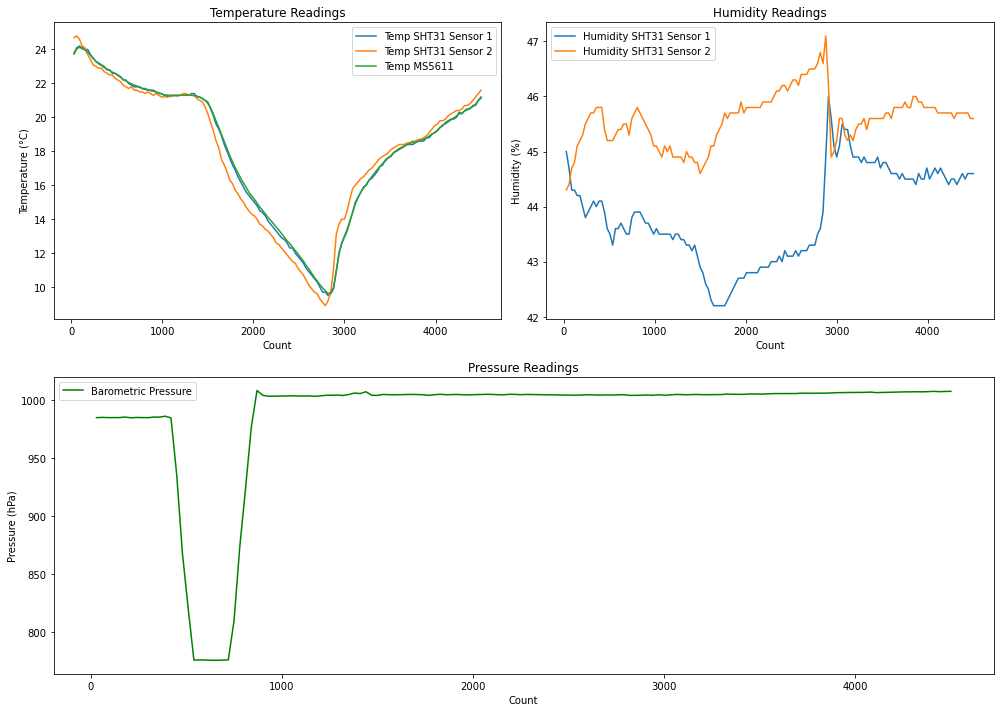

In [3]:
# Re-define the function to parse the file for $ENV messages and extract their data
def parse_env_messages(file_path):
    env_data = []
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('$ENV'):
                parts = line.strip().split(',')
                env_data.append(parts[1:])  # Skip the $ENV part, extract the rest
    return env_data

# File path from initial file upload
file_path = './tests/AIRDOS04A_1.1.0-22-Beta.TXT'

# Parse the file for $ENV messages again
env_data = parse_env_messages(file_path)

# Convert the extracted data to a DataFrame for easier manipulation
env_df = pd.DataFrame(env_data, dtype=float, columns=['Count', 'Timestamp', 'Temp_SHT31_1', 'Humidity_SHT31_1', 'Temp_SHT31_2', 'Humidity_SHT31_2', 'Temp_MS5611', 'Pressure_MS5611'])

# Plotting all parameters against the count
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.plot(env_df['Count'], env_df['Temp_SHT31_1'], label='Temp SHT31 Sensor 1')
plt.plot(env_df['Count'], env_df['Temp_SHT31_2'], label='Temp SHT31 Sensor 2')
plt.plot(env_df['Count'], env_df['Temp_MS5611'], label='Temp MS5611')
plt.title('Temperature Readings')
plt.xlabel('Count')
plt.ylabel('Temperature (°C)')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(env_df['Count'], env_df['Humidity_SHT31_1'], label='Humidity SHT31 Sensor 1')
plt.plot(env_df['Count'], env_df['Humidity_SHT31_2'], label='Humidity SHT31 Sensor 2')
plt.title('Humidity Readings')
plt.xlabel('Count')
plt.ylabel('Humidity (%)')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(env_df['Count'], env_df['Pressure_MS5611'], label='Barometric Pressure', color='green')
plt.title('Pressure Readings')
plt.xlabel('Count')
plt.ylabel('Pressure (hPa)')
plt.legend()

plt.tight_layout()
plt.show()


The measured barometric pressure could be converted to a barometric altitude which corresponds to the pressure in the aircraft cabin

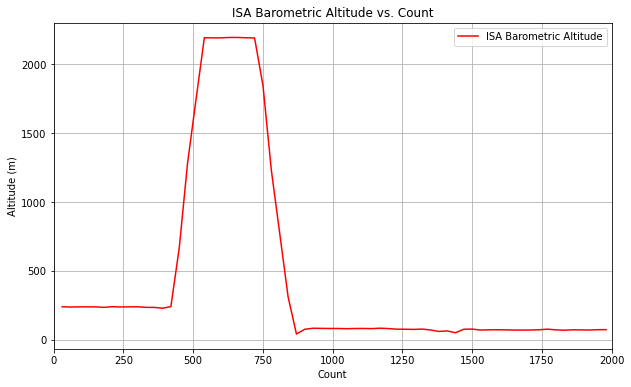

In [4]:
# Constants for the calculation
P0 = 101325  # Standard atmospheric pressure at sea level in Pascals

# Calculate ISA barometric altitude for each pressure reading
env_df['ISA_Altitude'] = 44330.8 * (1 - (env_df['Pressure_MS5611']*100 / P0) ** (1/5.255))

# Filter the DataFrame for the count range 0 to 2000 and plot altitude vs. count
filtered_env_df = env_df[(env_df['Count'] >= 0) & (env_df['Count'] <= 2000)]

plt.figure(figsize=(10, 6))
plt.plot(filtered_env_df['Count'], filtered_env_df['ISA_Altitude'], label='ISA Barometric Altitude', color='red')
plt.title('ISA Barometric Altitude vs. Count')
plt.xlabel('Count')
plt.ylabel('Altitude (m)')
plt.xlim(0, 2000)
plt.legend()
plt.grid(True)

plt.show()


There we could se that the cabin pressure in a arcraft corresponds roughly to altitude 2500 m a.m.s.l.